In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from model.CNN import CNN
from model.LSTM import LSTM
from libs import utils

%matplotlib inline

In [2]:
np.random.seed(42)
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

In [3]:
data_dir = 'data/stock_data.csv'
transformed_data = utils.stock_preprocess(data_dir)

In [4]:
train, valid, test = utils.stock_data_split(transformed_data)
(X_train, y_train), (X_valid, y_valid), (X_test, y_test), test_scaler = utils.stock_data2tensor(train, valid, test)

In [5]:
print('X Train shape ', X_train.shape)
print('X Valid shape ', X_valid.shape)
print('X Test shape', X_test.shape)

X Train shape  torch.Size([3826, 50, 5])
X Valid shape  torch.Size([1208, 50, 5])
X Test shape torch.Size([1023, 50, 5])


In [6]:
batch_size = 256

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

valid_data = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# Model

In [7]:
def choose_model(model_type):
    if model_type == 'singleLSTM':
        model = LSTM(5, 40, 1, 50, 1).cuda()
        save_path = 'results/singleLSTM/'
        save_file_name = save_path + 'SingleLSTMcarserv.pth'
    elif model_type == 'stackedLSTM':
        model = LSTM(5, 40, 1, 50, 2).cuda()
        save_path = 'results/stackedLSTM/'
        save_file_name = save_path + 'StackedLSTMcarserv.pth'
    elif model_type == 'CNN':
        model = CNN(5, [32, 64, 128], 1).cuda()
        save_path = 'results/CNN/'
        save_file_name = save_path + 'CNNcarserv.pth'
    return model, save_path, save_file_name

In [37]:
model_type = 'CNN'
model, save_path, save_file_name = choose_model(model_type)
print(model)

CNN(
  (block1): Sequential(
    (0): Conv1d(5, 32, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (conv1): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
)


In [38]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().cuda()
patience = 5
n_epochs = 300

In [40]:
with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    print(X.shape)
    print(y.shape)
    X = X.reshape(-1, 5, 50)
    exmodel = CNN(5, [32, 64, 128], 1).cuda()
    output = exmodel(X.cuda())
    print(output.shape)
    print(output)
    criterion = nn.MSELoss()
    loss = criterion(output.squeeze(), y.cuda())

torch.Size([256, 50, 5])
torch.Size([256])
torch.Size([256, 1, 1])
tensor([[[0.0487]],

        [[0.0509]],

        [[0.0519]],

        [[0.0564]],

        [[0.0543]],

        [[0.0551]],

        [[0.0584]],

        [[0.0599]],

        [[0.0554]],

        [[0.0484]],

        [[0.0465]],

        [[0.0460]],

        [[0.0457]],

        [[0.0487]],

        [[0.0478]],

        [[0.0455]],

        [[0.0433]],

        [[0.0470]],

        [[0.0475]],

        [[0.0501]],

        [[0.0517]],

        [[0.0482]],

        [[0.0467]],

        [[0.0467]],

        [[0.0467]],

        [[0.0503]],

        [[0.0536]],

        [[0.0557]],

        [[0.0526]],

        [[0.0542]],

        [[0.0562]],

        [[0.0552]],

        [[0.0525]],

        [[0.0541]],

        [[0.0519]],

        [[0.0447]],

        [[0.0420]],

        [[0.0426]],

        [[0.0395]],

        [[0.0402]],

        [[0.0370]],

        [[0.0360]],

        [[0.0331]],

        [[0.0322]],

        [

# Train

In [41]:
def fit(model, batch_size, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    best_loss = 9999999999
    patience = 0
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            if model_type == 'CNN':
                data, target = data.reshape(-1, 5, 50).cuda(), target.cuda()
            else:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.reshape(-1), target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            if model_type == 'CNN':
                data, target = data.reshape(-1, 5, 50).cuda(), target.cuda()
            else:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.reshape(-1), target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = 0
            torch.save(model.state_dict(), save_file_name)
            print('Saving Model')
        else:
            patience += 1
            print('Patience for ', patience)
        if patience == 10:
            break

    model.load_state_dict(torch.load(save_file_name))

    return  model, avg_train_losses, avg_valid_losses

In [42]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data, target in test_loader:
        if model_type == 'CNN':
            data, target = data.reshape(-1, 5, 50).cuda(), target.cuda()
        else:
            data, target = data.cuda(), target.cuda()
        y_test.append(target.cpu().numpy())
        output = model(data)
        y_hat.append(output.reshape(-1).detach().cpu().numpy())
        loss = criterion(output.reshape(-1), target)
        test_loss += loss.item()
    return test_loss/len(test_loader), y_test, y_hat

In [43]:
model, train_loss, valid_loss = fit(model, batch_size, patience, n_epochs)

[  1/300] train_loss: 0.94984 valid_loss: 0.80154
Saving Model
[  2/300] train_loss: 0.81382 valid_loss: 0.70948
Saving Model
[  3/300] train_loss: 0.70451 valid_loss: 0.60747
Saving Model
[  4/300] train_loss: 0.58372 valid_loss: 0.48822
Saving Model
[  5/300] train_loss: 0.44914 valid_loss: 0.35986
Saving Model
[  6/300] train_loss: 0.31071 valid_loss: 0.24193
Saving Model
[  7/300] train_loss: 0.18685 valid_loss: 0.15384
Saving Model
[  8/300] train_loss: 0.09793 valid_loss: 0.10628
Saving Model
[  9/300] train_loss: 0.05647 valid_loss: 0.09003
Saving Model
[ 10/300] train_loss: 0.04674 valid_loss: 0.08512
Saving Model
[ 11/300] train_loss: 0.04312 valid_loss: 0.08388
Saving Model
[ 12/300] train_loss: 0.04047 valid_loss: 0.08295
Saving Model
[ 13/300] train_loss: 0.03813 valid_loss: 0.08125
Saving Model
[ 14/300] train_loss: 0.03599 valid_loss: 0.07927
Saving Model
[ 15/300] train_loss: 0.03401 valid_loss: 0.07732
Saving Model
[ 16/300] train_loss: 0.03214 valid_loss: 0.07551
Savin

In [34]:
model.load_state_dict(torch.load(save_file_name))

<All keys matched successfully>

In [44]:
test_loss, y_target, y_hat = evaluate_model(model, test_loader)

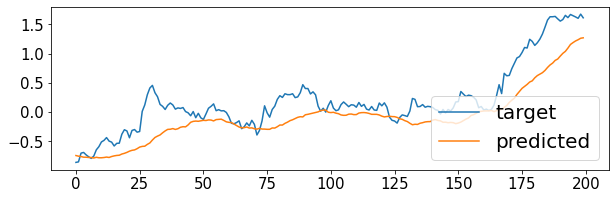

In [45]:
plt.figure(figsize=(10, 3))
plt.plot(y_target[:200], label='target')
plt.plot(y_hat[:200], label='predicted')
plt.legend(loc='lower right', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [46]:
print('Test Loss :', test_loss)

Test Loss : 0.15830124362792053
